In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import glob
import collections
%matplotlib inline

In [33]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh= (0,255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

In [34]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*sobel_mag/np.max(sobel_mag))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sxbinary

In [35]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output


In [36]:
def s_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]

    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    return binary_output


In [37]:
def h_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h = hls[:,:,0]
    
    binary_output = np.zeros_like(h)
    binary_output[(h > thresh[0]) & (h <= thresh[1])] = 1
    return binary_output


In [38]:
def camera_calibrate(chessboard_size, open_path, save_path):
    i = chessboard_size[0]
    j = chessboard_size[1]
    objp = np.zeros((i*j,3), np.float32)
    objp[:,:2] = np.mgrid[0:i, 0:j].T.reshape(-1,2)

    objpoints = [] 
    imgpoints = [] 
    images = glob.glob(open_path)
    count = 0 
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = save_path+'corners_found'+str(idx + 1)+'.jpg'
            cv2.imwrite(write_name, img)
        else:
            count += 1
    return objpoints, imgpoints

In [39]:
def undistort_img(img, objpoints, imgpoints):
    h, w = img.shape[:2]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w,h), None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [40]:
def perspective_trans(img):
    sizex = img.shape[0] # 720
    sizey = img.shape[1] # 1280
    src = np.float32([[588,470], [245,719], [1142, 719],[734,470]])
    dst = np.float32([[320,0], [320,720], [960, 720],[960,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (sizey, sizex), flags=cv2.INTER_LINEAR)
    return {'warped':warped, 'dst':dst, 'src':src, 'Minv': Minv}


In [41]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]  
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
           
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [42]:
def curvature_eval(binary_warped, nwindows = 20, margin = 50, minpix = 50):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_height = np.int(binary_warped.shape[0]/nwindows)
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ym_per_pix = 30.0/720 
    xm_per_pix = 3.7/700 
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    y_eval = binary_warped.shape[0] - 1 
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    offset_val = xm_per_pix * 0.5 * (binary_warped.shape[1] - (leftx_base + rightx_base))
    
    if offset_val < 0:
        offset_dir = 'left'
    else:
        offset_dir = 'right'
    offset = {'offset_val':offset_val, 'offset_dir':offset_dir}
    
    return {'left_fit':left_fit,'right_fit':right_fit, 'nonzerox':nonzerox,'nonzeroy':nonzeroy,\
            'left_lane_inds':left_lane_inds,'right_lane_inds':right_lane_inds,\
            'left_curverad':left_curverad, 'right_curverad':right_curverad,\
            'right_fit_cr':right_fit_cr,'offset':offset, 'out_img':out_img }


In [43]:
def map_color(Minv, warped, undist, left_fitx, right_fitx, ploty):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [44]:
def map_curv(img, curvature, offset):
    font = cv2.FONT_HERSHEY_SIMPLEX;
    offset_val = offset['offset_val']
    offset_dir = offset['offset_dir']
    curv_text = 'Radius of curvature is: ' + str(curvature) + ' m' 
    offset_text = 'Car is offset: ' + str(abs(offset_val)) + ' m towards ' + offset_dir
    cv2.putText(img, curv_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(img, offset_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    return img               

In [45]:
open_path = 'camera_cal/calibration*.jpg'
save_path = 'camera_cal/'
chessboard_size = [9, 6]
objpoints = []
imgpoints = []
objpoints, imgpoints = camera_calibrate(chessboard_size, open_path, save_path)

Text(0.5, 1.0, 'Undistorted Image')

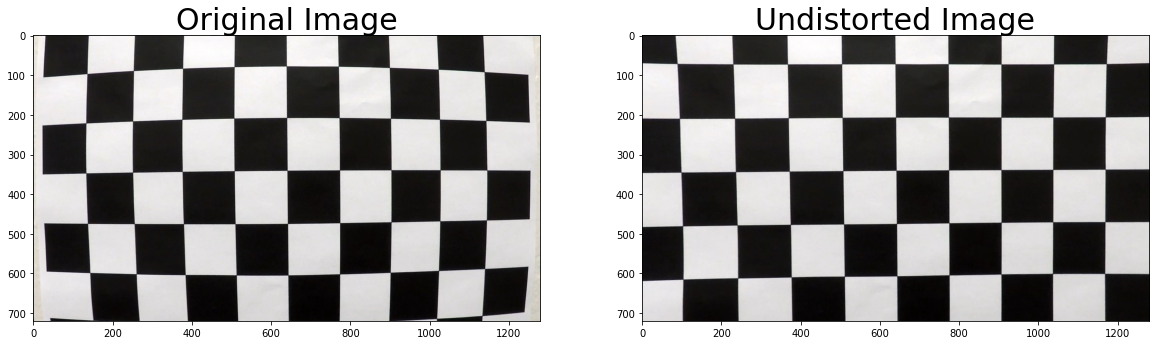

In [46]:
calib3_img = mpimg.imread('camera_cal/calibration1.jpg')
calib3_und_img = undistort_img(calib3_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(calib3_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calib3_und_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [47]:
pip install Pillow

Note: you may need to restart the kernel to use updated packages.


Text(0.5, 1.0, 'Undistorted Image')

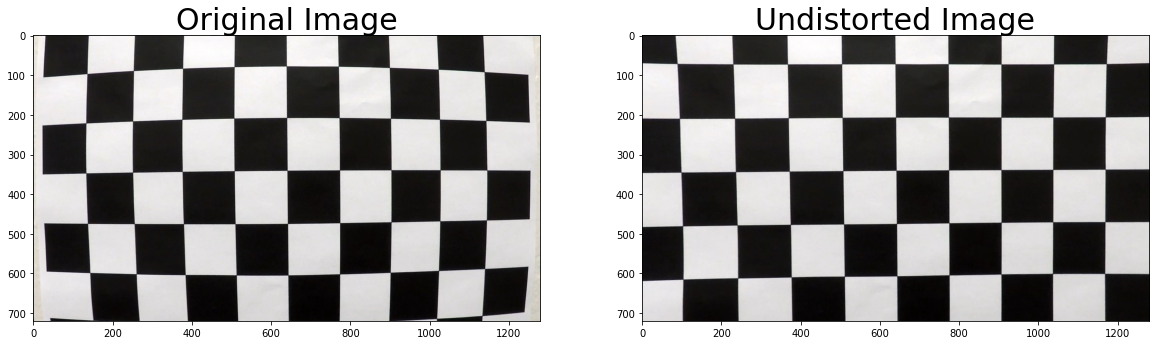

In [48]:
calib3_img = mpimg.imread('camera_cal/calibration1.jpg')
calib3_und_img = undistort_img(calib3_img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(calib3_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calib3_und_img)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Undistorted Image')

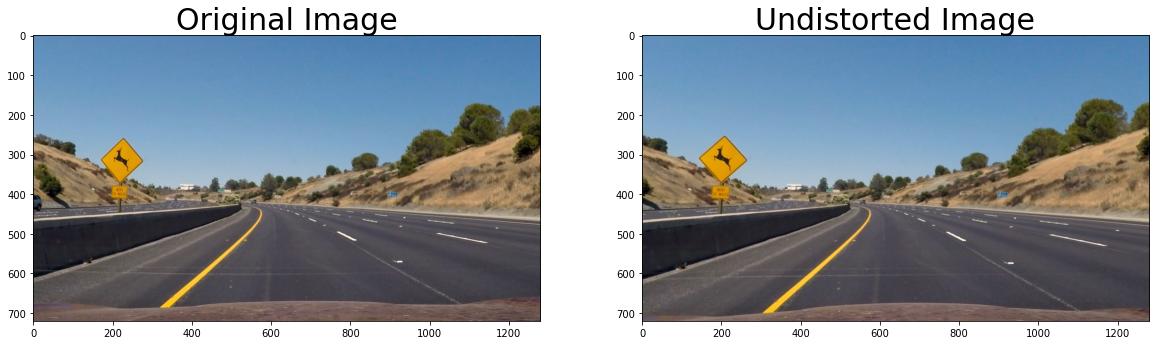

In [49]:
load_path = 'test_images/test' + str(random.randint(1,6)) + '.jpg'
img = mpimg.imread(load_path)
und_img = undistort_img(img, objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(und_img)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Thresholded Magnitude')

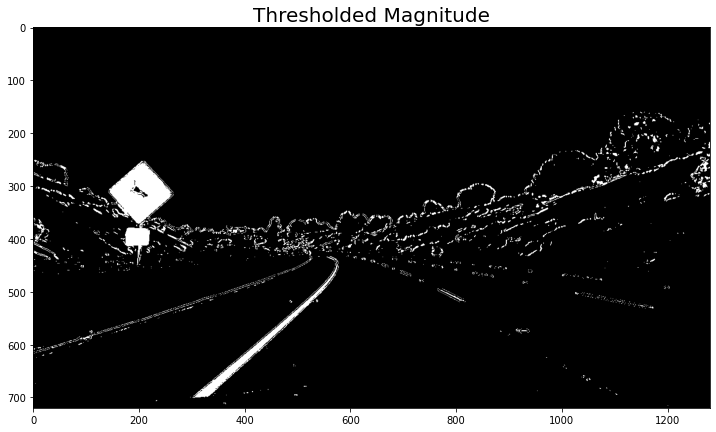

In [50]:
ksize = 5
img = und_img
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(50, 100))
s_binary = s_select(img, thresh=(150, 255))
combined = np.zeros_like(gradx)
combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1

f, ax = plt.subplots(1,1, figsize=(16, 7))
ax.imshow(combined, cmap='gray')
ax.set_title('Thresholded Magnitude', fontsize=20)



Text(0.5, 1.0, 'After Perspective Transform')

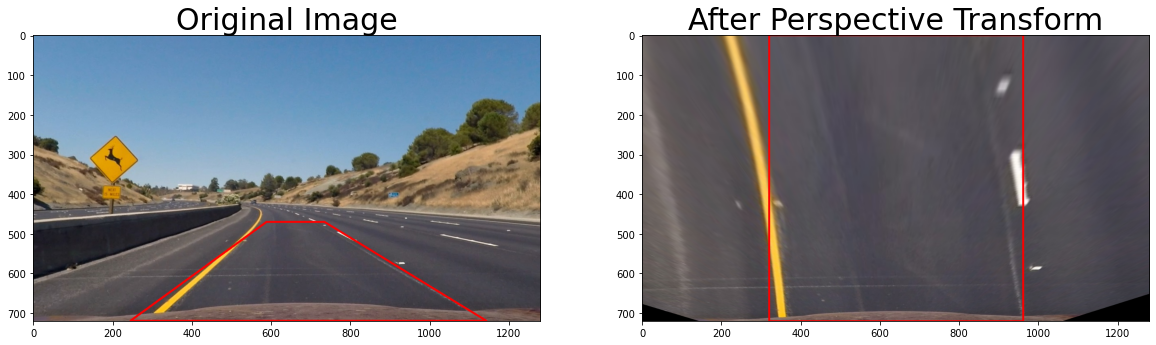

In [51]:
img = und_img
persp_obj = perspective_trans(img)
warped = persp_obj['warped']
dst = persp_obj['dst']
src = persp_obj['src']
Minv = persp_obj['Minv']

pts1 = np.array(src, np.int32)
pts1 = pts1.reshape((-1,1,2))
cv2.polylines(img,[pts1],True,(255,0,0),3)

pts2 = np.array(dst, np.int32)
pts2 = pts2.reshape((-1,1,2))
cv2.polylines(warped,[pts2],True,(255,0,0),3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('After Perspective Transform', fontsize=30)
    

The radius of curvature is: 830.9440090334609
The car is offset -0.037000000000000005 towards left.


Text(0.5, 1.0, 'Lane lines identified')

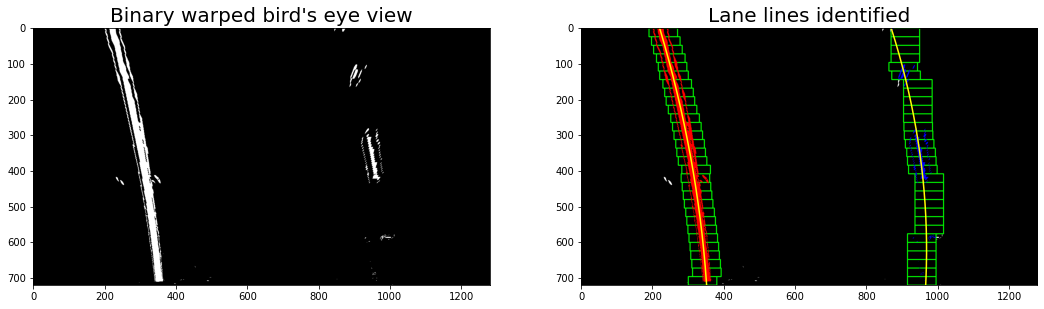

In [52]:
pers_obj2 = perspective_trans(combined)
binary_warped = pers_obj2['warped']
curv_obj = curvature_eval(binary_warped, nwindows = 30, margin = 40, minpix = 40)
left_fit = curv_obj['left_fit']
right_fit = curv_obj['right_fit']
nonzerox = curv_obj['nonzerox']
nonzeroy = curv_obj['nonzeroy']
left_lane_inds = curv_obj['left_lane_inds']
right_lane_inds = curv_obj['right_lane_inds']
offset = curv_obj['offset']
out_img = curv_obj['out_img']
curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
print('The radius of curvature is: ' + str(curvature))
print('The car is offset ' + str(offset['offset_val']) + ' towards ' + offset['offset_dir'] + '.')

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18,9))
ax1.imshow(binary_warped, cmap = 'gray')
ax1.set_title('Binary warped bird\'s eye view', fontsize = 20)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Lane lines identified', fontsize = 20)

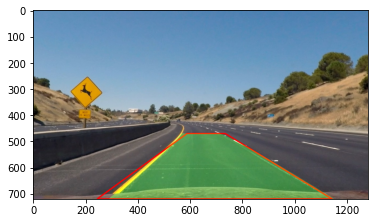

In [53]:
plt.imshow(map_color(Minv, binary_warped, und_img, left_fitx, right_fitx, ploty))

In [54]:
def process_img(img, M_inv=Minv, obj_points=objpoints, img_points=imgpoints, ksize=5, nwindows=40, margin=40, minpix=40):
    und_img = undistort_img(img, obj_points, img_points) 
    gradx = abs_sobel_thresh(und_img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(und_img, sobel_kernel=ksize, mag_thresh=(50, 100))
    s_binary = s_select(und_img, thresh=(150, 255))
    combined = np.zeros_like(gradx)
    combined[(((gradx == 1) & (mag_binary == 1))| (s_binary == 1))] = 1
    persp_obj = perspective_trans(combined)
    warped = persp_obj['warped']
    Minv = persp_obj['Minv']
    curv_obj = curvature_eval(warped, 40, 40, 40)
    left_fit = curv_obj['left_fit']
    right_fit = curv_obj['right_fit']
    left_lane_inds = curv_obj['left_lane_inds']
    right_lane_inds = curv_obj['right_lane_inds']
    offset = curv_obj['offset']
    left_curverad = curv_obj['left_curverad']
    right_curverad = curv_obj['right_curverad']
    curvature = 0.5 * (curv_obj['left_curverad'] + curv_obj['right_curverad'])
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
    lane_img = map_curv(lane_img, curvature, offset)
    return {'left_fit':left_fit, 'right_fit':right_fit, 'lane_img':lane_img, \
            'offset':offset, 'curvature':curvature, 'left_lane_inds':left_lane_inds,\
            'right_lane_inds':right_lane_inds, 'left_curverad':left_curverad,\
            'right_curverad':right_curverad, 'warped':warped, 'ploty':ploty, 'M_inv':M_inv, 'und_img':und_img}

In [55]:
class MyVideoProcessor(object):

    def __init__(self):
        self.count = 0
        self.past_frames_left = collections.deque(maxlen=10)
        self.past_frames_right = collections.deque(maxlen=10)

        self.last_fit_left = []
        self.last_fit_right = []

        self.left_curverad = []
        self.right_curverad = []
        self.curvature = []
        
        self.offset = []
        
        self.best_fit_left = None 
        self.best_fit_right = None 

    def pipeline_function(self, frame):
        if self.count < 10:
            pipeline = process_img(frame)
            self.past_frames_left.append(pipeline['left_fit'])
            self.past_frames_right.append(pipeline['right_fit'])
            if self.count == 9:
                self.last_fit_left = pipeline['left_fit']
                self.last_fit_right = pipeline['right_fit']
                self.left_curverad = pipeline['left_curverad']
                self.right_curverad = pipeline['right_curverad']
                self.curvature = pipeline['curvature']
                self.offset = pipeline['offset']
                self.best_fit_left = np.mean(self.past_frames_left, axis = 0)
                self.best_fit_right = np.mean(self.past_frames_right, axis = 0)
            self.count += 1
            return pipeline['lane_img']
        
        else:
            previous_left_fit = self.last_fit_left
            previous_right_fit = self.last_fit_right
            previous_left_curv = self.left_curverad
            previous_right_curv = self.right_curverad
            previous_curvature = self.curvature
            previous_offset = self.offset
            avg_left_fit = self.best_fit_left
            avg_right_fit = self.best_fit_right
            y_delx = frame.shape[0] - 1
            prev_delx = abs(avg_left_fit[0]*y_delx**2 + avg_left_fit[1]*y_delx + avg_left_fit[2] \
            - avg_right_fit[0]*y_delx**2 + avg_right_fit[1]*y_delx + avg_right_fit[2])
            
            pipeline = process_img(frame)
            und_img = pipeline['und_img']
            current_left_fit = pipeline['left_fit']
            current_right_fit = pipeline['right_fit']
            current_left_curv = pipeline['left_curverad']
            current_right_curv = pipeline['right_curverad']
            current_curvature = pipeline['curvature']
            current_offset = pipeline['offset']
            current_delx = abs(current_left_fit[0]*y_delx**2 + current_left_fit[1]*y_delx + current_left_fit[2] \
            - current_right_fit[0]*y_delx**2 + current_right_fit[1]*y_delx + current_right_fit[2])         

            if (current_left_fit.shape[0] == 0) | (current_right_fit.shape[0] == 0) | \
             (abs(current_curvature) > 10000) | (abs(current_curvature) < 800) | (current_delx > 1550) | (current_delx < 1100):
                current_left_fit = avg_left_fit
                current_right_fit = avg_right_fit
                current_curvature = previous_curvature
                current_offset = previous_offset
                
            self.past_frames_left.append(current_left_fit)
            self.past_frames_right.append(current_right_fit)
            current_avg_left_fit = np.mean(self.past_frames_left, axis = 0)
            current_avg_right_fit = np.mean(self.past_frames_right, axis = 0) 
            self.best_fit_left = current_avg_left_fit 
            self.best_fit_right = current_avg_right_fit
            self.curvature = current_curvature
            self.offset = current_offset
            
            M_inv = pipeline['M_inv']
            warped = pipeline['warped']
            ploty = pipeline['ploty']
            left_fitx = current_avg_left_fit[0]*ploty**2 + current_avg_left_fit[1]*ploty + current_avg_left_fit[2]
            right_fitx = current_avg_right_fit[0]*ploty**2 + current_avg_right_fit[1]*ploty + current_avg_right_fit[2]
            lane_img = map_color(M_inv, warped, und_img, left_fitx, right_fitx, ploty)
            lane_img = map_curv(lane_img, current_curvature, current_offset)
            self.count += 1
            return lane_img

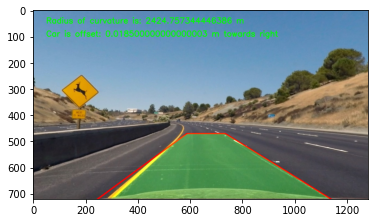

In [56]:
process_img_obj = process_img(img, Minv, objpoints, imgpoints, 5, 40, 40, 40)
plt.imshow(process_img_obj['lane_img'])

In [57]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
pip install moviepy

    100% |████████████████████████████████| 389kB 759kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/1a/70/1935c770cb3be6e3a8b78ced23d7e0f3b187f5cbfab4749523ed65d7c9b1/requests-2.23.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 71kB 3.8MB/s eta 0:00:01
    100% |████████████████████████████████| 3.3MB 383kB/s ta 0:00:01
  Using cached https://files.pythonhosted.org/packages/e1/e5/df302e8017440f111c11cc41a6b432838672f5a70aa29227bf58149dc72f/urllib3-1.25.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/57/2b/26e37a4b034800c960a00c4e1b3d9ca5d7014e983e6e729e33ea2f36426c/certifi-2020.4.5.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/89/e3/afebe61c546d18fb1709a61bee788254b40e736cff7271c7de5de2dc4128/idna-2.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/bc/a9/01ffebfb562e4274b6487b4bb1ddec7ca55ec7510b22e4c51f14098443b8/chardet-3.0.4-py2.py3-none-any.whl
  Run

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [29]:
my_video_processor_object = MyVideoProcessor()
output = 'project_video_output_v2_1.mp4'
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(my_video_processor_object.pipeline_function)

%time white_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output_v2_1.mp4.
Moviepy - Writing video project_video_output_v2_1.mp4



Moviepy - Done !
Moviepy - video ready project_video_output_v2_1.mp4
CPU times: user 18min 5s, sys: 11.2 s, total: 18min 16s
Wall time: 15min 22s
